# Learning sampling pattern
Second version of the full algorithm:
- Several images possible
- Learning points or cartesian mask

In [1]:
from mri.operators import NonCartesianFFT, WaveletUD2, WaveletN
import pysap
from mri.operators.utils import convert_mask_to_locations, convert_locations_to_mask
from modopt.math.metrics import ssim
import matplotlib.pyplot as plt
import numpy as np
import nibabel as nib

/home/guillaume/anaconda3/lib/python3.7/site-packages/mri/operators/fourier/non_cartesian.py:42: UserWarning: gpuNUFFT python package has not been found. If needed please check on how to install in README
  warnings.warn("gpuNUFFT python package has not been found. If needed "



                 .|'''|       /.\      '||'''|,
                 ||          // \\      ||   ||
'||''|, '||  ||` `|'''|,    //...\\     ||...|'
 ||  ||  `|..||   .   ||   //     \\    ||
 ||..|'      ||   |...|' .//       \\. .||
 ||       ,  |'
.||        ''

Package version: 0.0.3

License: CeCILL-B

Authors: 

Antoine Grigis <antoine.grigis@cea.fr>
Samuel Farrens <samuel.farrens@cea.fr>
Jean-Luc Starck <jl.stark@cea.fr>
Philippe Ciuciu <philippe.ciuciu@cea.fr>

Dependencies: 

scipy          : >=1.3.0   - required | 1.3.0     installed
numpy          : >=1.16.4  - required | 1.16.4    installed
matplotlib     : >=3.0.0   - required | 3.1.1     installed
astropy        : >=3.0.0   - required | 3.2.1     installed
nibabel        : >=2.3.2   - required | 2.5.1     installed
pyqtgraph      : >=0.10.0  - required | 0.10.0    installed
progressbar2   : >=3.34.3  - required | ?         installed
modopt         : >=1.4.0   - required | 1.4.4     installed
scikit-learn   : >=0.19.1  - requi

In [2]:
# Lower level imports
from LowerLevel.pdhg import pdhg

#Upper level imports
import time
from UpperLevel.LBFGSB import *
from UpperLevel.cost_utils import *

### Creation of Lower level tools
Creating fourier_op, linear_op and param.

In [3]:
#Size of images to use
n = 200

x = np.linspace(0,n,n,endpoint=False)/n-0.5
y = np.linspace(0,n,n,endpoint=False)/n-0.5
X,Y = np.meshgrid(x,y)
kspace_loc = np.stack([X.flatten('F'),Y.flatten('F')],axis=1)

m = convert_locations_to_mask(kspace_loc,(n,n))
fourier_op = NonCartesianFFT(samples=kspace_loc, shape=(n,n),implementation='cpu')

/home/guillaume/anaconda3/lib/python3.7/site-packages/mri/operators/fourier/utils.py:76: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  mask[test] = 1


In [4]:
#Wavelet
wavelet_name = "sym8"
wavelet_scale = 3
linear_op = WaveletN(wavelet_name=wavelet_name,nb_scale=wavelet_scale,padding_mode = "periodization")
#linear_op = WaveletUD2(wavelet_id=24,nb_scale=3)

param = {"epsilon":1e-3,"gamma":1e-10}

### Initializing upper level
Creating images, kspace_data and updating param

In [5]:
#Oasis image
im = nib.load("oasis_data/T2w/sub-OAS30001_sess-d0129_acq-TSE_T2w.nii")
im = im.get_fdata()

Nimages = 5
images = [(1+0j)*im[ :, :, i ]for i in range(Nimages)]
test_images = [(1+0j)*im[ :, :, 15+i ]for i in range(20)]

In [6]:
def reduce_img_size( n_dim, image ):
    mid = image.shape[ 0 ] // 2
    f_coef = np.fft.fftshift( np.fft.fft2( image ) )
    reduced_coef = f_coef[ mid - n_dim // 2: mid + n_dim // 2, mid - n_dim // 2: mid + n_dim // 2 ]
    reduced_image = np.fft.ifft2( np.fft.fftshift( reduced_coef ) )
    return np.abs( reduced_image )

images = [reduce_img_size(n,im) for im in images]
test_images = [reduce_img_size(n,im) for im in test_images]
kspace_data = [(1+0j)*fourier_op.op(u0_mat)+0.15*np.mean(u0_mat)*np.random.randn(2*n*n).view(np.complex128) 
               for u0_mat in images]
test_kspace_data = [(1+0j)*fourier_op.op(u0_mat)+0.15*np.mean(u0_mat)*np.random.randn(2*n*n).view(np.complex128) 
               for u0_mat in test_images]

In [7]:
ssim(fourier_op.adj_op(kspace_data[0]),images[0])

0.838028633844744

In [8]:
param["c"] = 1e-8
param["beta"] = 2e-5

In [9]:
# -- Main object to learn mask --
# -------------------------------
obj = Mask_Learner(images=images,kspace_data=kspace_data,
                    samples= np.array(kspace_loc) , wavelet_name = wavelet_name , wavelet_scale = wavelet_scale ,
                    param=param , verbose=-1 , my_const={"sigma":5,"tau":0.1} , maxiter=20 , maxfun=20)

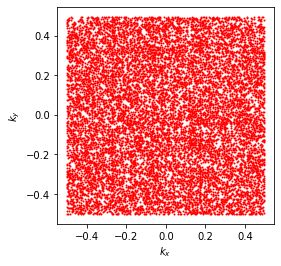

In [10]:
ptest = np.zeros(n**2)
for i in range(n**2):
    ptest[i] = 0 if np.random.rand()>0.3 else 1
    
ceiled_mask = []
for i in range(n**2):
    if ptest[i]==1:
        ceiled_mask.append(kspace_loc[i])
ceiled_mask = np.array(ceiled_mask)
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.scatter(ceiled_mask[:,0], ceiled_mask[:,1], s=1, c='r')
ax.set_aspect( 'equal' )
plt.xlabel(r"$k_x$")
plt.ylabel(r"$k_y$")
plt.savefig("underdampling.png")
plt.show()
#print( kspace_loc.shape[ 0 ] / ( n_dim * n_dim ) )

# Learning points independantly

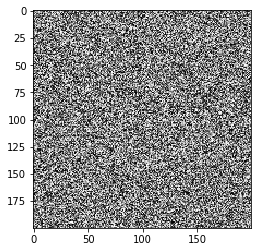

Penalty: 0.3990348810186792 
Energy: 20.503672875397385


In [12]:
p0 = np.random.rand(n**2+1)
p0[-1] = 1e1

plt.figure()
plt.imshow(np.reshape(p0[:-1],(n,n)),cmap='gray')
#plt.savefig("Results/Upper Level/Penalty_strength_V2/Initial_mask.png")
plt.show()

print("Penalty:",P(p0,param["beta"]),
      "\nEnergy:",E(pk=p0 , images=images , kspace_data=kspace_data , samples = kspace_loc ,
                    wavelet_name = wavelet_name , wavelet_scale = wavelet_scale , param=param , verbose=-1 ,
                    const=obj.const))

In [13]:
pf,energy_upper,alphas = obj.optimize(p0=p0 , parallel=True , parallel_verbose=1)

Multithread: True


EVALUATING GRAD_E(p)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  2.6min remaining:  4.0min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.9min finished




EVALUATING GRAD_E(p)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  1.5min remaining:  2.2min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.0min finished



1 iterations: E(p)=17.84588722452877, alpha=10.186362603340621




EVALUATING GRAD_E(p)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  1.8min remaining:  2.7min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.3min finished



2 iterations: E(p)=11.767130905600526, alpha=10.556840462124688




EVALUATING GRAD_E(p)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  1.6min remaining:  2.4min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.4min finished



3 iterations: E(p)=9.739569744062441, alpha=10.7608113712858




EVALUATING GRAD_E(p)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  1.7min remaining:  2.6min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.4min finished



4 iterations: E(p)=6.863946543582122, alpha=11.112552817357404




EVALUATING GRAD_E(p)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  1.9min remaining:  2.8min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.3min finished



5 iterations: E(p)=4.97150534889938, alpha=11.407270507342911




EVALUATING GRAD_E(p)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  1.6min remaining:  2.3min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.0min finished



6 iterations: E(p)=3.558413334273477, alpha=11.693692698753237




EVALUATING GRAD_E(p)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  1.7min remaining:  2.6min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.7min finished



7 iterations: E(p)=2.668120330010786, alpha=11.979515606978131




EVALUATING GRAD_E(p)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  2.0min remaining:  3.0min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.6min finished



8 iterations: E(p)=2.1925746785148204, alpha=12.320357841718048




EVALUATING GRAD_E(p)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  2.2min remaining:  3.3min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.3min finished



9 iterations: E(p)=1.9505629029133726, alpha=12.896304427162045




EVALUATING GRAD_E(p)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  1.7min remaining:  2.6min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.4min finished



10 iterations: E(p)=1.671798108440192, alpha=14.977670413925056




EVALUATING GRAD_E(p)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  2.8min remaining:  4.2min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  5.4min finished



11 iterations: E(p)=1.414055593221418, alpha=18.396316088169947




EVALUATING GRAD_E(p)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  5.2min remaining:  7.8min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  7.5min finished




EVALUATING GRAD_E(p)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  4.4min remaining:  6.6min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  5.5min finished



12 iterations: E(p)=1.294065486926791, alpha=21.763716840967554




EVALUATING GRAD_E(p)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  4.8min remaining:  7.2min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 10.7min finished



13 iterations: E(p)=1.2058899616729344, alpha=27.32276824653505




EVALUATING GRAD_E(p)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed: 12.4min remaining: 18.6min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 14.8min finished



14 iterations: E(p)=1.0848041116114167, alpha=37.465394328215474




EVALUATING GRAD_E(p)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed: 13.8min remaining: 20.8min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 15.5min finished




EVALUATING GRAD_E(p)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed: 13.7min remaining: 20.5min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 15.1min finished



15 iterations: E(p)=1.0627472942620708, alpha=38.572582465903196




EVALUATING GRAD_E(p)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed: 12.9min remaining: 19.3min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 17.4min finished




EVALUATING GRAD_E(p)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed: 14.1min remaining: 21.1min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 15.2min finished




EVALUATING GRAD_E(p)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed: 12.0min remaining: 18.0min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 15.0min finished



16 iterations: E(p)=0.9541908756823679, alpha=38.629570414432955



FINISHED IN 10573.964793920517 SECONDS



20.503672875397385 0.9541908756823679


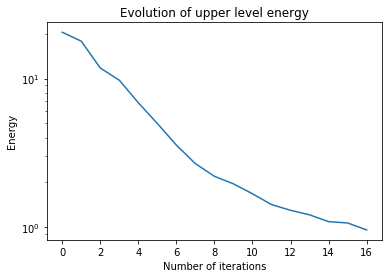

In [14]:
print(energy_upper[0],energy_upper[-1])
plt.plot(energy_upper)
plt.title("Evolution of upper level energy")
plt.xlabel("Number of iterations")
plt.ylabel("Energy")
plt.yscale("log")
#plt.savefig("Results/Upper Level/Multiple images/20 images/convergence.png")

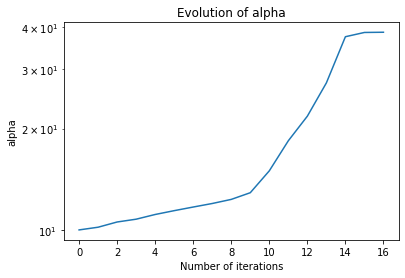

In [15]:
plt.plot(alphas)
plt.title("Evolution of alpha")
plt.xlabel("Number of iterations")
plt.ylabel("alpha")
plt.yscale("log")
#plt.savefig("Results/Upper Level/Multiple images/20 images/alpha.png")

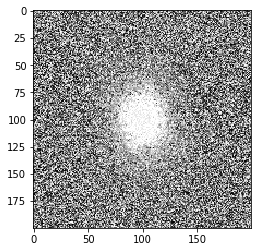

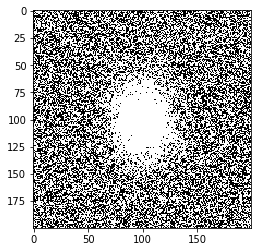

In [16]:
ceiled_pf = np.where(pf>0.5,1,0)
ceiled_pf[-1]=pf[-1]

plt.figure()
plt.imshow(np.reshape(pf[:-1],(n,n)),cmap='gray')
#plt.savefig("Results/Upper Level/Other pen/Modified pen/pf.png")
plt.figure()
plt.imshow(np.reshape(ceiled_pf[:-1],(n,n)),cmap='gray')
#plt.savefig("Results/Upper Level/Multiple images/20 images/ceiled_pf.png")
plt.show()

In [17]:
print("Penalty:",P(pf,param["beta"]),
      "\nEnergy:",E(pk=pf , images=images , kspace_data=kspace_data , samples= kspace_loc ,
                    wavelet_name = wavelet_name , wavelet_scale = wavelet_scale , param=param ,
                    verbose=-1 , const=obj.const),
      "\nNumber of points:",np.sum(ceiled_pf))

Penalty: 0.4313781278770231 
Energy: 0.9541908756823679 
Number of points: 22247


Text(0.5, 1.0, 'Histogram of $p_i$')

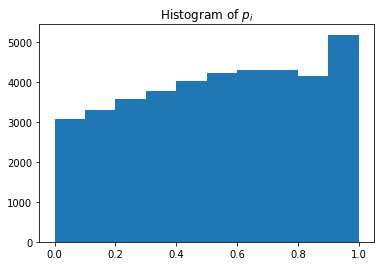

In [18]:
plt.hist(pf[:-1])
plt.title(r"Histogram of $p_i$")
#plt.savefig("Results/Upper Level/Other pen/Modified pen/histogram.png")

In [19]:
# -- Compute mean ssim of final mask and its ceiled version --
mean_ssim_pf = 0
mean_ssim_ceiled = 0

for itest in range(Nimages):
    uk,norms = pdhg(kspace_data[itest] , ceiled_pf , fourier_op = fourier_op , linear_op = linear_op , param = param,
                    maxit = 50 , verbose = -1 , const = obj.const)
    mean_ssim_ceiled += ssim(uk,images[itest])
    
    uk,norms = pdhg(kspace_data[itest] , pf , fourier_op = fourier_op , linear_op = linear_op , param = param,
                    maxit = 50 , verbose = -1 , const = obj.const)
    mean_ssim_pf += ssim(uk,images[itest])
print(f"\nMean ssim: {mean_ssim_pf/Nimages}\nMean ssim ceiled mask:{mean_ssim_ceiled/Nimages}")


Mean ssim: 0.7976295858057114
Mean ssim ceiled mask:0.7305103717160474


In [20]:
# -- Evaluate on fixed set of images --
ssim_pf = np.zeros(len(test_images))
ssim_ceiled = np.zeros(len(test_images))

for itest in range(len(test_images)):
    uk,norms = pdhg(test_kspace_data[itest] , ceiled_pf , fourier_op = fourier_op , linear_op = linear_op , param = param,
                    maxit = 50 , verbose = -1 , const = obj.const)
    ssim_ceiled[itest] = ssim(uk,test_images[itest])
    
    uk,norms = pdhg(test_kspace_data[itest] , pf , fourier_op = fourier_op , linear_op = linear_op , param = param,
                    maxit = 50 , verbose = -1 , const = obj.const)
    ssim_pf[itest] = ssim(uk,test_images[itest])
print(f"\nMean ssim: {np.mean(ssim_pf)}, std:{np.std(ssim_pf)}",
      f"\nMean ssim ceiled mask:{np.mean(ssim_ceiled)}, std:{np.std(ssim_ceiled)}")

KeyboardInterrupt: 

In [21]:
#np.savetxt("saved_densities/T2w_medpen_200.csv",pf,delimiter=",")

# Learning cartesian pattern

In [ ]:
l0 = np.random.rand(n+1)
l0[-1] = 1e0

param["beta"] = 5e0

# -- Main object to learn mask --
# -------------------------------
obj = Mask_Learner(images=images,kspace_data=kspace_data,
                    fourier_op=fourier_op , linear_op=linear_op , param=param , 
                    verbose=-1 , my_const={"sigma":5,"tau":0.1} , maxiter=40 , maxfun=40)

cartesian_p = pcart(l0)
cartesian_p[-1] = l0[-1]
print(param["beta"]*np.sum(l0[:-1]),P(l0,param["beta"]))

plt.figure()
plt.imshow(np.reshape(cartesian_p[:-1],(n,n)),cmap='gray')
#plt.savefig("Results/Upper Level/Upper_example/shots/convergence.png")
plt.show()

In [ ]:
#lf,energy_upper,alphas = obj.optimize(mask_type = "cartesian" , l0=l0)

In [ ]:
print(energy_upper[0],energy_upper[-1])
plt.plot(energy_upper)
plt.title("Evolution of upper level energy")
plt.xlabel("Number of iterations")
plt.ylabel("Energy")
plt.yscale("log")
#plt.savefig("Results/Upper Level/Upper_example/shots/convergence.png")

In [ ]:
plt.plot(alphas)
plt.title("Evolution of alpha")
plt.xlabel("Number of iterations")
plt.ylabel("alpha")
plt.yscale("log")
#plt.savefig("Results/Upper Level/Upper_example/shots/alpha.png")

In [ ]:
print(lf)
pf = pcart(lf)
ceiled_pf = np.where(pf>0.5,1,0)

plt.figure()
plt.imshow(np.reshape(pf[:-1],(n,n)),cmap='gray',vmin=0,vmax=1)
#plt.savefig("Results/Upper Level/Upper_example/shots/pf.png")
plt.figure()
plt.imshow(np.reshape(ceiled_pf[:-1],(n,n)),cmap='gray')
#plt.savefig("Results/Upper Level/Upper_example/shots/ceiled_pf.png")
plt.show()

In [ ]:
print(P(lf,param["beta"]),
E(lk=lf , mask_type = "cartesian" , images=images , kspace_data=kspace_data , fourier_op=fourier_op ,
           linear_op=linear_op , param=param , verbose=-1 , const=obj.const),
np.sum(ceiled_pf))

In [ ]:
mean_ssim_pf = 0
mean_ssim_ceiled = 0
pfull = np.ones(len(pf))
pfull[-1] = pf[-1]

for itest in range(Nimages):
    uk,norms = pdhg(kspace_data[itest] , ceiled_pf , fourier_op = fourier_op , linear_op = linear_op , param = param,
                    maxit = 50 , verbose = -1 , const = obj.const)
    mean_ssim_ceiled += ssim(uk,images[itest])
    
    uk,norms = pdhg(kspace_data[itest] , pf , fourier_op = fourier_op , linear_op = linear_op , param = param,
                    maxit = 50 , verbose = -1 , const = obj.const)
    mean_ssim_pf += ssim(uk,images[itest])
print(f"\nMean ssim: {mean_ssim_pf/Nimages}\nMean ssim ceiled mask:{mean_ssim_ceiled/Nimages}")